# Image Segmentation by Supervised Learning

## import libraries

In [331]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [332]:
directory_data  = './'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## hyper-parameters

In [333]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 400
size_minibatch  = 50
learning_rate   = 0.05
weight_decay    = 0.009

## custom data loader for the PyTorch framework

In [334]:
class dataset(Dataset):
    
    def __init__(self, image, label, transform=0):
        
        self.image  = image
        self.label  = label 
        self.transform = transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)

        image   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
        label   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)

        if self.transform == 1:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,2])
            label = torch.flip(label, [0,2])
            
            #
            # ==================================================

        if self.transform == 2:
            # ==================================================
            # you can apply data augmentation here
            #
            
            image = torch.flip(image, [0,1])
            label = torch.flip(label, [0,1])
            
            #
            # ==================================================
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [335]:
dataset_train_transform = dataset(x_train, y_train, transform=1)
dataset_train_transform_ud = dataset(x_train, y_train, transform=2)
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train_transform_ud  = DataLoader(dataset_train_transform_ud, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 64, 64])
shape of the label in the training dataset: torch.Size([1, 64, 64])


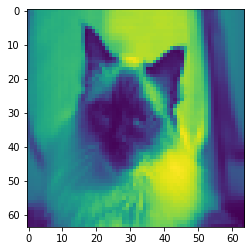

*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 64, 64])
shape of the label in the testing dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the training transform dataset: torch.Size([1, 64, 64])
shape of the label in the training transform dataset: torch.Size([1, 64, 64])


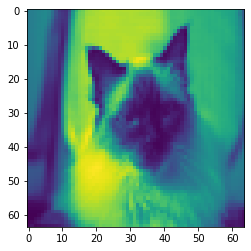

*******************************************************************


In [336]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
(image_train_transform, label_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
plt.imshow(image_train[0], interpolation='nearest')
plt.show()
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')
print('shape of the image in the training transform dataset:', image_train_transform.shape)
print('shape of the label in the training transform dataset:', label_train_transform.shape)
plt.imshow(image_train_transform[0], interpolation='nearest')
plt.show()
print('*******************************************************************')

## class for the neural network 

In [337]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        
        self.e_layers = nn.Sequential(
                        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.BatchNorm2d(16),
                        nn.ReLU(),
                        nn.MaxPool2d(2,2),
                        
                        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),  
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        # nn.MaxPool2d(2,2),
                        

                        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(64),
												nn.ReLU(),
                        # nn.MaxPool2d(2,2),

                        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(128),
												nn.ReLU(),
                        # nn.MaxPool2d(2,2),

                        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(256),
												nn.ReLU(),
                        nn.MaxPool2d(2,2),

                        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(512),
												nn.ReLU(),
                        nn.MaxPool2d(2,2),
                        
                        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(512),
												nn.ReLU(),
                       

        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------

        
        self.d_layers = nn.Sequential(
          
                        # nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                        # nn.BatchNorm2d(256),
												# nn.ReLU(),

                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(256),
												nn.ReLU(),

                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(128),
												nn.ReLU(),
                        
                        # nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(64),
												nn.ReLU(),


                        # nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(32),
												nn.ReLU(),

                        # nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.BatchNorm2d(16),
												nn.ReLU(),
                        
                        nn.Upsample(scale_factor=2, mode='nearest'),
                        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
                        nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
                        self.e_layers, 
                        self.d_layers,
        )

        self.initialize_weight()

    def forward(self,x):
        out = self.network(x)
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self): 
        for m in self.network.modules():

            if isinstance(m, nn.Conv2d):
                m.reset_parameters()
                # xavier(m.weight.data)
                # xavier(m.bias.data)

            elif isinstance(m, nn.BatchNorm2d):
                m.reset_parameters()
                # xavier(m.weight.data)
                # xavier(m.bias.data)

            elif isinstance(m, nn.Linear):
                m.reset_parameters()

In [338]:
# class Network(nn.Module): 

# 	def __init__(self, in_channel=1, out_channel=1, dim_feature=8, dim_code=8, threshold_ReLU=0.01):
        
# 		super(Network, self).__init__()

# 		self.in_channel 	= in_channel
# 		self.out_channel	= out_channel
# 		self.dim_feature	= dim_feature
		
# 		self.conv_encode1	= nn.Conv2d(in_channel , dim_feature * 1, kernel_size=3, stride=2, padding=1, bias=True)
# 		self.conv_encode2	= nn.Conv2d(dim_feature * 1, dim_feature * 2, kernel_size=3, stride=2, padding=1, bias=True)
# 		self.conv_middle	= nn.Conv2d(dim_feature * 2, dim_feature * 4, kernel_size=3, stride=1, padding=1, bias=True)
# 		self.conv_decode2 	= nn.Conv2d(dim_feature * 4, dim_feature * 2, kernel_size=3, stride=1, padding=1, bias=True)
# 		self.conv_decode1 	= nn.Conv2d(dim_feature * 2, dim_feature * 1,	kernel_size=3, stride=1, padding=1, bias=True)
# 		self.conv_out 		= nn.Conv2d(dim_feature * 1, out_channel,	kernel_size=1, stride=1, padding=0, bias=True)

# 		self.ebn1			= nn.BatchNorm2d(dim_feature * 1)
# 		self.ebn2			= nn.BatchNorm2d(dim_feature * 2)
# 		self.mbn		 	= nn.BatchNorm2d(dim_feature * 4)
# 		self.dbn2			= nn.BatchNorm2d(dim_feature * 2)
# 		self.dbn1			= nn.BatchNorm2d(dim_feature * 1)

# 		self.activation		= nn.ReLU(inplace=True)
# 		self.activation_out	= nn.Sigmoid()

# 		# *********************************************************************
# 		# forward propagation
# 		# *********************************************************************
# 	def forward(self, x):

# 		x1  = self.conv_encode1(x)
# 		eb1 = self.ebn1(x1)
# 		e1  = self.activation(eb1)

# 		x2  = self.conv_encode2(e1)
# 		eb2 = self.ebn2(x2)
# 		e2  = self.activation(eb2)
		
# 		m   = self.conv_middle(e2)
# 		mb  = self.mbn(m)
# 		c   = self.activation(mb)

# 		y2  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(c)
# 		y2  = self.conv_decode2(y2) 
# 		db2 = self.dbn2(y2)
# 		d2  = self.activation(db2)
		
# 		y1  = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)(d2)
# 		y1  = self.conv_decode1(y1) 
# 		db1 = self.dbn1(y1)
# 		d1  = self.activation(db1)
		
# 		y1  = self.conv_out(d1)
# 		y = self.activation_out(y1)

# 		return y


## build network

In [339]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [340]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [341]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    mse = nn.MSELoss()
    loss = mse(label, prediction)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [342]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [343]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [344]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [345]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [346]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']
    print(accuracy_mean_test[i])

  0%|▏                                                                                 | 1/400 [00:02<17:46,  2.67s/it]

49.84289575077599


  0%|▍                                                                                 | 2/400 [00:05<17:28,  2.63s/it]

1.9270915531072852


  1%|▌                                                                                 | 3/400 [00:07<17:29,  2.64s/it]

56.89634212050072


  1%|▊                                                                                 | 4/400 [00:10<17:27,  2.65s/it]

55.87259271718686


  1%|█                                                                                 | 5/400 [00:13<17:24,  2.65s/it]

63.21764172377462


  2%|█▏                                                                                | 6/400 [00:15<17:18,  2.64s/it]

53.23744614505437


  2%|█▍                                                                                | 7/400 [00:18<17:12,  2.63s/it]

62.36984204743132


  2%|█▋                                                                                | 8/400 [00:21<17:07,  2.62s/it]

64.57585811956932


  2%|█▊                                                                                | 9/400 [00:23<17:04,  2.62s/it]

63.762420719712445


  2%|██                                                                               | 10/400 [00:26<17:00,  2.62s/it]

62.63876604707214


  3%|██▏                                                                              | 11/400 [00:28<16:56,  2.61s/it]

62.87258051123773


  3%|██▍                                                                              | 12/400 [00:31<16:53,  2.61s/it]

39.43696485047826


  3%|██▋                                                                              | 13/400 [00:34<16:50,  2.61s/it]

60.52327901406966


  4%|██▊                                                                              | 14/400 [00:36<16:48,  2.61s/it]

39.63410193819599


  4%|███                                                                              | 15/400 [00:39<16:44,  2.61s/it]

59.286092145020504


  4%|███▏                                                                             | 16/400 [00:41<16:42,  2.61s/it]

63.744750586649005


  4%|███▍                                                                             | 17/400 [00:44<16:40,  2.61s/it]

63.887647416522576


  4%|███▋                                                                             | 18/400 [00:47<16:38,  2.61s/it]

61.81804015920383


  5%|███▊                                                                             | 19/400 [00:49<16:36,  2.61s/it]

53.808358776920414


  5%|████                                                                             | 20/400 [00:52<16:33,  2.61s/it]

61.22446868831613


  5%|████▎                                                                            | 21/400 [00:55<16:30,  2.61s/it]

59.40528893418379


  6%|████▍                                                                            | 22/400 [00:57<16:28,  2.61s/it]

63.60920016231547


  6%|████▋                                                                            | 23/400 [01:00<16:25,  2.61s/it]

63.11490111023157


  6%|████▊                                                                            | 24/400 [01:02<16:23,  2.62s/it]

59.50622568126262


  6%|█████                                                                            | 25/400 [01:05<16:20,  2.61s/it]

59.734626157536965


  6%|█████▎                                                                           | 26/400 [01:08<16:18,  2.62s/it]

62.93682906814674


  7%|█████▍                                                                           | 27/400 [01:10<16:15,  2.62s/it]

59.595131110655025


  7%|█████▋                                                                           | 28/400 [01:13<16:12,  2.62s/it]

57.32111521120972


  7%|█████▊                                                                           | 29/400 [01:15<16:10,  2.61s/it]

64.13793963208161


  8%|██████                                                                           | 30/400 [01:18<16:07,  2.61s/it]

58.228389613824405


  8%|██████▎                                                                          | 31/400 [01:21<16:04,  2.61s/it]

62.7106667237679


  8%|██████▍                                                                          | 32/400 [01:23<16:02,  2.61s/it]

65.56046294466987


  8%|██████▋                                                                          | 33/400 [01:26<15:59,  2.61s/it]

62.85205045857093


  8%|██████▉                                                                          | 34/400 [01:29<15:57,  2.62s/it]

65.71401241629358


  9%|███████                                                                          | 35/400 [01:31<15:54,  2.62s/it]

65.22410734588885


  9%|███████▎                                                                         | 36/400 [01:34<15:52,  2.62s/it]

64.52828580390226


  9%|███████▍                                                                         | 37/400 [01:36<15:49,  2.62s/it]

59.48654260467905


 10%|███████▋                                                                         | 38/400 [01:39<15:46,  2.62s/it]

61.59674589905608


 10%|███████▉                                                                         | 39/400 [01:42<15:44,  2.62s/it]

64.53180383624604


 10%|████████                                                                         | 40/400 [01:44<15:41,  2.62s/it]

62.683611280146906


 10%|████████▎                                                                        | 41/400 [01:47<15:38,  2.62s/it]

65.01395669769755


 10%|████████▌                                                                        | 42/400 [01:49<15:36,  2.61s/it]

60.96290967792773


 11%|████████▋                                                                        | 43/400 [01:52<15:33,  2.62s/it]

62.9502098786405


 11%|████████▉                                                                        | 44/400 [01:55<15:31,  2.62s/it]

60.54630398365726


 11%|█████████                                                                        | 45/400 [01:57<15:28,  2.62s/it]

64.69328644685223


 12%|█████████▎                                                                       | 46/400 [02:00<15:25,  2.62s/it]

65.29550478855705


 12%|█████████▌                                                                       | 47/400 [02:03<15:23,  2.62s/it]

65.27119768474712


 12%|█████████▋                                                                       | 48/400 [02:05<15:20,  2.62s/it]

65.45245692313058


 12%|█████████▉                                                                       | 49/400 [02:08<15:18,  2.62s/it]

65.61067575745153


 12%|██████████▏                                                                      | 50/400 [02:10<15:15,  2.61s/it]

62.65261957758619


 13%|██████████▎                                                                      | 51/400 [02:13<15:12,  2.62s/it]

64.46056956714807


 13%|██████████▌                                                                      | 52/400 [02:16<15:10,  2.62s/it]

65.31672326724296


 13%|██████████▋                                                                      | 53/400 [02:18<15:07,  2.62s/it]

65.27903020808658


 14%|██████████▉                                                                      | 54/400 [02:21<15:04,  2.61s/it]

64.37562535681658


 14%|███████████▏                                                                     | 55/400 [02:23<15:02,  2.62s/it]

43.149652414472854


 14%|███████████▎                                                                     | 56/400 [02:26<14:59,  2.62s/it]

59.81221790311187


 14%|███████████▌                                                                     | 57/400 [02:29<14:57,  2.62s/it]

60.60611304800756


 14%|███████████▋                                                                     | 58/400 [02:31<14:54,  2.61s/it]

62.38214871294145


 15%|███████████▉                                                                     | 59/400 [02:34<14:51,  2.62s/it]

65.26114622450854


 15%|████████████▏                                                                    | 60/400 [02:37<14:49,  2.62s/it]

66.25082539519467


 15%|████████████▎                                                                    | 61/400 [02:39<14:46,  2.62s/it]

66.1065085745721


 16%|████████████▌                                                                    | 62/400 [02:42<14:44,  2.62s/it]

64.89238113939537


 16%|████████████▊                                                                    | 63/400 [02:44<14:41,  2.62s/it]

64.0887170378738


 16%|████████████▉                                                                    | 64/400 [02:47<14:39,  2.62s/it]

65.33922649889806


 16%|█████████████▏                                                                   | 65/400 [02:50<14:36,  2.62s/it]

66.27796415349181


 16%|█████████████▎                                                                   | 66/400 [02:52<14:33,  2.62s/it]

66.2078311321432


 17%|█████████████▌                                                                   | 67/400 [02:55<14:31,  2.62s/it]

66.33548428424348


 17%|█████████████▊                                                                   | 68/400 [02:57<14:28,  2.62s/it]

62.8404891630737


 17%|█████████████▉                                                                   | 69/400 [03:00<14:25,  2.62s/it]

66.33405198231854


 18%|██████████████▏                                                                  | 70/400 [03:03<14:23,  2.62s/it]

65.1797212780499


 18%|██████████████▍                                                                  | 71/400 [03:05<14:21,  2.62s/it]

66.3408820509207


 18%|██████████████▌                                                                  | 72/400 [03:08<14:19,  2.62s/it]

66.24888836087561


 18%|██████████████▊                                                                  | 73/400 [03:11<14:16,  2.62s/it]

61.927855991960094


 18%|██████████████▉                                                                  | 74/400 [03:13<14:14,  2.62s/it]

65.00013371556125


 19%|███████████████▏                                                                 | 75/400 [03:16<14:12,  2.62s/it]

66.37795586102045


 19%|███████████████▍                                                                 | 76/400 [03:18<14:09,  2.62s/it]

64.83805734936291


 19%|███████████████▌                                                                 | 77/400 [03:21<14:06,  2.62s/it]

64.95041979265278


 20%|███████████████▊                                                                 | 78/400 [03:24<14:04,  2.62s/it]

66.34831830674223


 20%|███████████████▉                                                                 | 79/400 [03:26<14:01,  2.62s/it]

65.84374259503078


 20%|████████████████▏                                                                | 80/400 [03:29<13:59,  2.62s/it]

64.96617178765152


 20%|████████████████▍                                                                | 81/400 [03:32<13:56,  2.62s/it]

65.80923461496295


 20%|████████████████▌                                                                | 82/400 [03:34<13:53,  2.62s/it]

64.81379362115831


 21%|████████████████▊                                                                | 83/400 [03:37<13:50,  2.62s/it]

49.15974534881776


 21%|█████████████████                                                                | 84/400 [03:39<13:48,  2.62s/it]

31.44608424255808


 21%|█████████████████▏                                                               | 85/400 [03:42<13:45,  2.62s/it]

61.30777168851928


 22%|█████████████████▍                                                               | 86/400 [03:45<13:43,  2.62s/it]

59.599976897587176


 22%|█████████████████▌                                                               | 87/400 [03:47<13:40,  2.62s/it]

65.2895605343726


 22%|█████████████████▊                                                               | 88/400 [03:50<13:37,  2.62s/it]

65.06526953936137


 22%|██████████████████                                                               | 89/400 [03:53<13:35,  2.62s/it]

66.48155245646717


 22%|██████████████████▏                                                              | 90/400 [03:55<13:32,  2.62s/it]

66.68097823371178


 23%|██████████████████▍                                                              | 91/400 [03:58<13:30,  2.62s/it]

65.66811927645821


 23%|██████████████████▋                                                              | 92/400 [04:00<13:27,  2.62s/it]

66.41932857781978


 23%|██████████████████▊                                                              | 93/400 [04:03<13:24,  2.62s/it]

66.05297095287347


 24%|███████████████████                                                              | 94/400 [04:06<13:22,  2.62s/it]

66.23529186270007


 24%|███████████████████▏                                                             | 95/400 [04:08<13:19,  2.62s/it]

64.44875482098975


 24%|███████████████████▍                                                             | 96/400 [04:11<13:16,  2.62s/it]

65.6282650914369


 24%|███████████████████▋                                                             | 97/400 [04:13<13:14,  2.62s/it]

66.75438420759792


 24%|███████████████████▊                                                             | 98/400 [04:16<13:11,  2.62s/it]

65.68411487244491


 25%|████████████████████                                                             | 99/400 [04:19<13:08,  2.62s/it]

64.26729748701948


 25%|████████████████████                                                            | 100/400 [04:21<13:06,  2.62s/it]

66.7095023530185


 25%|████████████████████▏                                                           | 101/400 [04:24<13:05,  2.63s/it]

65.80106379030724


 26%|████████████████████▍                                                           | 102/400 [04:27<13:03,  2.63s/it]

65.32172582412497


 26%|████████████████████▌                                                           | 103/400 [04:29<13:01,  2.63s/it]

65.91241389849395


 26%|████████████████████▊                                                           | 104/400 [04:32<12:59,  2.63s/it]

64.72735990646996


 26%|█████████████████████                                                           | 105/400 [04:35<12:55,  2.63s/it]

64.61078558497289


 26%|█████████████████████▏                                                          | 106/400 [04:37<12:52,  2.63s/it]

66.56687332322886


 27%|█████████████████████▍                                                          | 107/400 [04:40<12:49,  2.63s/it]

65.34527073972666


 27%|█████████████████████▌                                                          | 108/400 [04:42<12:46,  2.62s/it]

66.71076077137592


 27%|█████████████████████▊                                                          | 109/400 [04:45<12:43,  2.62s/it]

64.47559772141443


 28%|██████████████████████                                                          | 110/400 [04:48<12:40,  2.62s/it]

65.11140565428784


 28%|██████████████████████▏                                                         | 111/400 [04:50<12:38,  2.62s/it]

65.95926080695544


 28%|██████████████████████▍                                                         | 112/400 [04:53<12:35,  2.62s/it]

65.44192314417653


 28%|██████████████████████▌                                                         | 113/400 [04:55<12:32,  2.62s/it]

65.69668849380244


 28%|██████████████████████▊                                                         | 114/400 [04:58<12:29,  2.62s/it]

66.83725694421227


 29%|███████████████████████                                                         | 115/400 [05:01<12:27,  2.62s/it]

65.7130701906089


 29%|███████████████████████▏                                                        | 116/400 [05:03<12:24,  2.62s/it]

64.73881275673827


 29%|███████████████████████▍                                                        | 117/400 [05:06<12:22,  2.62s/it]

65.07022770371543


 30%|███████████████████████▌                                                        | 118/400 [05:09<12:19,  2.62s/it]

65.28954391318881


 30%|███████████████████████▊                                                        | 119/400 [05:11<12:16,  2.62s/it]

21.592137655368077


 30%|████████████████████████                                                        | 120/400 [05:14<12:14,  2.62s/it]

51.300451446651195


 30%|████████████████████████▏                                                       | 121/400 [05:16<12:11,  2.62s/it]

51.132157795980866


 30%|████████████████████████▍                                                       | 122/400 [05:19<12:08,  2.62s/it]

60.70868431383752


 31%|████████████████████████▌                                                       | 123/400 [05:22<12:06,  2.62s/it]

62.9558500576843


 31%|████████████████████████▊                                                       | 124/400 [05:24<12:03,  2.62s/it]

65.6864238104646


 31%|█████████████████████████                                                       | 125/400 [05:27<12:01,  2.62s/it]

66.41850300610504


 32%|█████████████████████████▏                                                      | 126/400 [05:30<11:58,  2.62s/it]

67.13981450421801


 32%|█████████████████████████▍                                                      | 127/400 [05:32<11:55,  2.62s/it]

67.27522770044644


 32%|█████████████████████████▌                                                      | 128/400 [05:35<11:53,  2.62s/it]

66.56477456209996


 32%|█████████████████████████▊                                                      | 129/400 [05:37<11:50,  2.62s/it]

66.11199311229807


 32%|██████████████████████████                                                      | 130/400 [05:40<11:47,  2.62s/it]

65.47948085823592


 33%|██████████████████████████▏                                                     | 131/400 [05:43<11:45,  2.62s/it]

67.29636166566657


 33%|██████████████████████████▍                                                     | 132/400 [05:45<11:42,  2.62s/it]

65.9203222887246


 33%|██████████████████████████▌                                                     | 133/400 [05:48<11:40,  2.62s/it]

66.62740900058778


 34%|██████████████████████████▊                                                     | 134/400 [05:51<11:37,  2.62s/it]

67.02294237729092


 34%|███████████████████████████                                                     | 135/400 [05:53<11:34,  2.62s/it]

65.62936488841096


 34%|███████████████████████████▏                                                    | 136/400 [05:56<11:32,  2.62s/it]

66.19430694012391


 34%|███████████████████████████▍                                                    | 137/400 [05:58<11:29,  2.62s/it]

66.577171758198


 34%|███████████████████████████▌                                                    | 138/400 [06:01<11:27,  2.62s/it]

66.65876453177626


 35%|███████████████████████████▊                                                    | 139/400 [06:04<11:24,  2.62s/it]

67.40014822817014


 35%|████████████████████████████                                                    | 140/400 [06:06<11:21,  2.62s/it]

67.10908552367877


 35%|████████████████████████████▏                                                   | 141/400 [06:09<11:19,  2.62s/it]

66.68596027962896


 36%|████████████████████████████▍                                                   | 142/400 [06:12<11:16,  2.62s/it]

66.69427413494279


 36%|████████████████████████████▌                                                   | 143/400 [06:14<11:13,  2.62s/it]

65.38166830997629


 36%|████████████████████████████▊                                                   | 144/400 [06:17<11:11,  2.62s/it]

66.24886562208215


 36%|█████████████████████████████                                                   | 145/400 [06:19<11:08,  2.62s/it]

67.45211795785092


 36%|█████████████████████████████▏                                                  | 146/400 [06:22<11:05,  2.62s/it]

67.08404687250093


 37%|█████████████████████████████▍                                                  | 147/400 [06:25<11:03,  2.62s/it]

67.63859099967257


 37%|█████████████████████████████▌                                                  | 148/400 [06:27<11:00,  2.62s/it]

66.92969436822753


 37%|█████████████████████████████▊                                                  | 149/400 [06:30<10:58,  2.62s/it]

66.43320106809064


 38%|██████████████████████████████                                                  | 150/400 [06:33<10:55,  2.62s/it]

66.98974400401906


 38%|██████████████████████████████▏                                                 | 151/400 [06:35<10:53,  2.62s/it]

66.42730580074405


 38%|██████████████████████████████▍                                                 | 152/400 [06:38<10:50,  2.62s/it]

65.71420562680939


 38%|██████████████████████████████▌                                                 | 153/400 [06:40<10:47,  2.62s/it]

48.78640974378408


 38%|██████████████████████████████▊                                                 | 154/400 [06:43<10:45,  2.62s/it]

48.351642673977075


 39%|███████████████████████████████                                                 | 155/400 [06:46<10:42,  2.62s/it]

26.73015943358594


 39%|███████████████████████████████▏                                                | 156/400 [06:48<10:39,  2.62s/it]

61.42134273553082


 39%|███████████████████████████████▍                                                | 157/400 [06:51<10:36,  2.62s/it]

63.42491525150723


 40%|███████████████████████████████▌                                                | 158/400 [06:53<10:34,  2.62s/it]

65.40898032175672


 40%|███████████████████████████████▊                                                | 159/400 [06:56<10:31,  2.62s/it]

67.75998266185448


 40%|████████████████████████████████                                                | 160/400 [06:59<10:29,  2.62s/it]

67.82315909545358


 40%|████████████████████████████████▏                                               | 161/400 [07:01<10:26,  2.62s/it]

67.69018263319929


 40%|████████████████████████████████▍                                               | 162/400 [07:04<10:24,  2.62s/it]

67.12171940714768


 41%|████████████████████████████████▌                                               | 163/400 [07:07<10:21,  2.62s/it]

67.51628443175474


 41%|████████████████████████████████▊                                               | 164/400 [07:09<10:18,  2.62s/it]

66.54108612419964


 41%|█████████████████████████████████                                               | 165/400 [07:12<10:16,  2.62s/it]

67.86246451114667


 42%|█████████████████████████████████▏                                              | 166/400 [07:14<10:14,  2.63s/it]

67.16524984235684


 42%|█████████████████████████████████▍                                              | 167/400 [07:17<10:12,  2.63s/it]

67.21735141552296


 42%|█████████████████████████████████▌                                              | 168/400 [07:20<10:09,  2.63s/it]

67.08162821688954


 42%|█████████████████████████████████▊                                              | 169/400 [07:22<10:06,  2.63s/it]

66.87309287933331


 42%|██████████████████████████████████                                              | 170/400 [07:25<10:03,  2.62s/it]

66.7771383658368


 43%|██████████████████████████████████▏                                             | 171/400 [07:28<10:00,  2.62s/it]

67.92284364939762


 43%|██████████████████████████████████▍                                             | 172/400 [07:30<09:57,  2.62s/it]

66.77572321591094


 43%|██████████████████████████████████▌                                             | 173/400 [07:33<09:55,  2.62s/it]

66.20361187032223


 44%|██████████████████████████████████▊                                             | 174/400 [07:35<09:52,  2.62s/it]

68.0570641081546


 44%|███████████████████████████████████                                             | 175/400 [07:38<09:49,  2.62s/it]

66.89137513080891


 44%|███████████████████████████████████▏                                            | 176/400 [07:41<09:47,  2.62s/it]

66.62929882276333


 44%|███████████████████████████████████▍                                            | 177/400 [07:43<09:44,  2.62s/it]

66.02468096324888


 44%|███████████████████████████████████▌                                            | 178/400 [07:46<09:42,  2.62s/it]

66.55077671928053


 45%|███████████████████████████████████▊                                            | 179/400 [07:49<09:39,  2.62s/it]

66.55243930717856


 45%|████████████████████████████████████                                            | 180/400 [07:51<09:36,  2.62s/it]

67.06226741974993


 45%|████████████████████████████████████▏                                           | 181/400 [07:54<09:34,  2.62s/it]

67.7372621634915


 46%|████████████████████████████████████▍                                           | 182/400 [07:56<09:31,  2.62s/it]

66.15195905222359


 46%|████████████████████████████████████▌                                           | 183/400 [07:59<09:28,  2.62s/it]

67.12438910044676


 46%|████████████████████████████████████▊                                           | 184/400 [08:02<09:26,  2.62s/it]

66.74923332882236


 46%|█████████████████████████████████████                                           | 185/400 [08:04<09:23,  2.62s/it]

67.80633292026477


 46%|█████████████████████████████████████▏                                          | 186/400 [08:07<09:21,  2.62s/it]

67.1346565578988


 47%|█████████████████████████████████████▍                                          | 187/400 [08:10<09:18,  2.62s/it]

63.57521027278291


 47%|█████████████████████████████████████▌                                          | 188/400 [08:12<09:15,  2.62s/it]

66.85084667796706


 47%|█████████████████████████████████████▊                                          | 189/400 [08:15<09:13,  2.62s/it]

67.31454560950331


 48%|██████████████████████████████████████                                          | 190/400 [08:17<09:10,  2.62s/it]

64.98820349977655


 48%|██████████████████████████████████████▏                                         | 191/400 [08:20<09:07,  2.62s/it]

65.82751921961055


 48%|██████████████████████████████████████▍                                         | 192/400 [08:23<09:05,  2.62s/it]

67.11044355081147


 48%|██████████████████████████████████████▌                                         | 193/400 [08:25<09:02,  2.62s/it]

66.80530733872256


 48%|██████████████████████████████████████▊                                         | 194/400 [08:28<09:00,  2.62s/it]

67.44855985652609


 49%|███████████████████████████████████████                                         | 195/400 [08:31<08:57,  2.62s/it]

66.86883497175134


 49%|███████████████████████████████████████▏                                        | 196/400 [08:33<08:54,  2.62s/it]

67.72352781333055


 49%|███████████████████████████████████████▍                                        | 197/400 [08:36<08:52,  2.62s/it]

67.00764471379986


 50%|███████████████████████████████████████▌                                        | 198/400 [08:38<08:49,  2.62s/it]

66.61106809467825


 50%|███████████████████████████████████████▊                                        | 199/400 [08:41<08:47,  2.62s/it]

65.64615356956273


 50%|████████████████████████████████████████                                        | 200/400 [08:44<08:44,  2.62s/it]

66.94668552807124


 50%|████████████████████████████████████████▏                                       | 201/400 [08:46<08:41,  2.62s/it]

62.60341753218688


 50%|████████████████████████████████████████▍                                       | 202/400 [08:49<08:39,  2.62s/it]

43.26055457958452


 51%|████████████████████████████████████████▌                                       | 203/400 [08:51<08:36,  2.62s/it]

63.91674022665625


 51%|████████████████████████████████████████▊                                       | 204/400 [08:54<08:33,  2.62s/it]

30.089940672906764


 51%|█████████████████████████████████████████                                       | 205/400 [08:57<08:31,  2.62s/it]

60.84157864425856


 52%|█████████████████████████████████████████▏                                      | 206/400 [08:59<08:28,  2.62s/it]

46.774909589531454


 52%|█████████████████████████████████████████▍                                      | 207/400 [09:02<08:26,  2.62s/it]

58.40330532417126


 52%|█████████████████████████████████████████▌                                      | 208/400 [09:05<08:23,  2.62s/it]

66.4289261021753


 52%|█████████████████████████████████████████▊                                      | 209/400 [09:07<08:20,  2.62s/it]

67.04022002019056


 52%|██████████████████████████████████████████                                      | 210/400 [09:10<08:18,  2.62s/it]

69.00478694035968


 53%|██████████████████████████████████████████▏                                     | 211/400 [09:12<08:15,  2.62s/it]

68.1566689963582


 53%|██████████████████████████████████████████▍                                     | 212/400 [09:15<08:13,  2.62s/it]

68.67566295595537


 53%|██████████████████████████████████████████▌                                     | 213/400 [09:18<08:10,  2.62s/it]

68.78659813117174


 54%|██████████████████████████████████████████▊                                     | 214/400 [09:20<08:07,  2.62s/it]

67.12186019690428


 54%|███████████████████████████████████████████                                     | 215/400 [09:23<08:05,  2.62s/it]

68.61376462717952


 54%|███████████████████████████████████████████▏                                    | 216/400 [09:26<08:02,  2.62s/it]

68.76909318619832


 54%|███████████████████████████████████████████▍                                    | 217/400 [09:28<07:59,  2.62s/it]

68.2174505714228


 55%|███████████████████████████████████████████▌                                    | 218/400 [09:31<07:57,  2.62s/it]

68.12607450325045


 55%|███████████████████████████████████████████▊                                    | 219/400 [09:33<07:54,  2.62s/it]

69.214241056324


 55%|████████████████████████████████████████████                                    | 220/400 [09:36<07:51,  2.62s/it]

68.91220892770083


 55%|████████████████████████████████████████████▏                                   | 221/400 [09:39<07:49,  2.62s/it]

68.06235921314885


 56%|████████████████████████████████████████████▍                                   | 222/400 [09:41<07:46,  2.62s/it]

67.97154106502994


 56%|████████████████████████████████████████████▌                                   | 223/400 [09:44<07:43,  2.62s/it]

68.21400633656827


 56%|████████████████████████████████████████████▊                                   | 224/400 [09:47<07:41,  2.62s/it]

67.54995610229608


 56%|█████████████████████████████████████████████                                   | 225/400 [09:49<07:38,  2.62s/it]

62.10359789251858


 56%|█████████████████████████████████████████████▏                                  | 226/400 [09:52<07:36,  2.62s/it]

51.34908451602692


 57%|█████████████████████████████████████████████▍                                  | 227/400 [09:54<07:33,  2.62s/it]

52.06887247205922


 57%|█████████████████████████████████████████████▌                                  | 228/400 [09:57<07:30,  2.62s/it]

64.85671556296482


 57%|█████████████████████████████████████████████▊                                  | 229/400 [10:00<07:28,  2.62s/it]

66.07625429776868


 57%|██████████████████████████████████████████████                                  | 230/400 [10:02<07:25,  2.62s/it]

67.3258527197039


 58%|██████████████████████████████████████████████▏                                 | 231/400 [10:05<07:23,  2.62s/it]

69.026011472688


 58%|██████████████████████████████████████████████▍                                 | 232/400 [10:08<07:20,  2.62s/it]

66.53093325843105


 58%|██████████████████████████████████████████████▌                                 | 233/400 [10:10<07:17,  2.62s/it]

67.70591672500632


 58%|██████████████████████████████████████████████▊                                 | 234/400 [10:13<07:15,  2.62s/it]

68.38649561148107


 59%|███████████████████████████████████████████████                                 | 235/400 [10:15<07:12,  2.62s/it]

69.08505644688569


 59%|███████████████████████████████████████████████▏                                | 236/400 [10:18<07:10,  2.62s/it]

68.31751154242434


 59%|███████████████████████████████████████████████▍                                | 237/400 [10:21<07:07,  2.62s/it]

68.43237500243653


 60%|███████████████████████████████████████████████▌                                | 238/400 [10:23<07:04,  2.62s/it]

68.4387552668461


 60%|███████████████████████████████████████████████▊                                | 239/400 [10:26<07:02,  2.62s/it]

69.4521974073826


 60%|████████████████████████████████████████████████                                | 240/400 [10:29<06:59,  2.62s/it]

69.09723434393717


 60%|████████████████████████████████████████████████▏                               | 241/400 [10:31<06:56,  2.62s/it]

68.80786541223414


 60%|████████████████████████████████████████████████▍                               | 242/400 [10:34<06:54,  2.62s/it]

67.70778696041765


 61%|████████████████████████████████████████████████▌                               | 243/400 [10:36<06:51,  2.62s/it]

69.19992041319668


 61%|████████████████████████████████████████████████▊                               | 244/400 [10:39<06:49,  2.62s/it]

67.88269001271486


 61%|█████████████████████████████████████████████████                               | 245/400 [10:42<06:46,  2.62s/it]

68.92978390154086


 62%|█████████████████████████████████████████████████▏                              | 246/400 [10:44<06:43,  2.62s/it]

69.24952314809241


 62%|█████████████████████████████████████████████████▍                              | 247/400 [10:47<06:41,  2.62s/it]

69.09531709313522


 62%|█████████████████████████████████████████████████▌                              | 248/400 [10:49<06:38,  2.62s/it]

68.22982757018062


 62%|█████████████████████████████████████████████████▊                              | 249/400 [10:52<06:35,  2.62s/it]

68.88556612169151


 62%|██████████████████████████████████████████████████                              | 250/400 [10:55<06:33,  2.62s/it]

68.7191558629597


 63%|██████████████████████████████████████████████████▏                             | 251/400 [10:57<06:30,  2.62s/it]

69.04345343253709


 63%|██████████████████████████████████████████████████▍                             | 252/400 [11:00<06:27,  2.62s/it]

68.63333495351017


 63%|██████████████████████████████████████████████████▌                             | 253/400 [11:03<06:25,  2.62s/it]

69.01500458450141


 64%|██████████████████████████████████████████████████▊                             | 254/400 [11:05<06:22,  2.62s/it]

66.95374953318954


 64%|███████████████████████████████████████████████████                             | 255/400 [11:08<06:20,  2.62s/it]

68.12360061831762


 64%|███████████████████████████████████████████████████▏                            | 256/400 [11:10<06:17,  2.62s/it]

68.27133184707951


 64%|███████████████████████████████████████████████████▍                            | 257/400 [11:13<06:14,  2.62s/it]

68.63526233846959


 64%|███████████████████████████████████████████████████▌                            | 258/400 [11:16<06:12,  2.62s/it]

68.23192214810226


 65%|███████████████████████████████████████████████████▊                            | 259/400 [11:18<06:09,  2.62s/it]

69.32530269086759


 65%|████████████████████████████████████████████████████                            | 260/400 [11:21<06:07,  2.62s/it]

68.585961169255


 65%|████████████████████████████████████████████████████▏                           | 261/400 [11:24<06:04,  2.62s/it]

68.36840815110013


 66%|████████████████████████████████████████████████████▍                           | 262/400 [11:26<06:01,  2.62s/it]

68.70733744032358


 66%|████████████████████████████████████████████████████▌                           | 263/400 [11:29<05:59,  2.62s/it]

44.32597967388001


 66%|████████████████████████████████████████████████████▊                           | 264/400 [11:31<05:56,  2.62s/it]

47.63237927555154


 66%|█████████████████████████████████████████████████████                           | 265/400 [11:34<05:53,  2.62s/it]

35.52310065673024


 66%|█████████████████████████████████████████████████████▏                          | 266/400 [11:37<05:51,  2.62s/it]

58.93664808344516


 67%|█████████████████████████████████████████████████████▍                          | 267/400 [11:39<05:48,  2.62s/it]

63.57259410883252


 67%|█████████████████████████████████████████████████████▌                          | 268/400 [11:42<05:46,  2.62s/it]

67.44212946771131


 67%|█████████████████████████████████████████████████████▊                          | 269/400 [11:45<05:43,  2.62s/it]

69.57313400618621


 68%|██████████████████████████████████████████████████████                          | 270/400 [11:47<05:40,  2.62s/it]

68.47208928361772


 68%|██████████████████████████████████████████████████████▏                         | 271/400 [11:50<05:38,  2.62s/it]

68.12484325256503


 68%|██████████████████████████████████████████████████████▍                         | 272/400 [11:52<05:36,  2.63s/it]

68.64581728906641


 68%|██████████████████████████████████████████████████████▌                         | 273/400 [11:55<05:33,  2.63s/it]

67.66415664280487


 68%|██████████████████████████████████████████████████████▊                         | 274/400 [11:58<05:30,  2.63s/it]

69.24188771545985


 69%|███████████████████████████████████████████████████████                         | 275/400 [12:00<05:28,  2.63s/it]

69.00433928169312


 69%|███████████████████████████████████████████████████████▏                        | 276/400 [12:03<05:25,  2.62s/it]

68.56193473259351


 69%|███████████████████████████████████████████████████████▍                        | 277/400 [12:06<05:22,  2.62s/it]

68.60525676335888


 70%|███████████████████████████████████████████████████████▌                        | 278/400 [12:08<05:20,  2.62s/it]

69.2698749690638


 70%|███████████████████████████████████████████████████████▊                        | 279/400 [12:11<05:17,  2.62s/it]

68.98047921771139


 70%|████████████████████████████████████████████████████████                        | 280/400 [12:13<05:14,  2.62s/it]

69.32078904045736


 70%|████████████████████████████████████████████████████████▏                       | 281/400 [12:16<05:12,  2.62s/it]

69.60370358346238


 70%|████████████████████████████████████████████████████████▍                       | 282/400 [12:19<05:09,  2.62s/it]

68.1254693582693


 71%|████████████████████████████████████████████████████████▌                       | 283/400 [12:21<05:06,  2.62s/it]

69.16775348959841


 71%|████████████████████████████████████████████████████████▊                       | 284/400 [12:24<05:04,  2.62s/it]

69.5228585714155


 71%|█████████████████████████████████████████████████████████                       | 285/400 [12:27<05:01,  2.62s/it]

68.40764786947278


 72%|█████████████████████████████████████████████████████████▏                      | 286/400 [12:29<04:58,  2.62s/it]

68.07757128873584


 72%|█████████████████████████████████████████████████████████▍                      | 287/400 [12:32<04:56,  2.62s/it]

69.14734073269463


 72%|█████████████████████████████████████████████████████████▌                      | 288/400 [12:34<04:53,  2.62s/it]

68.54015495351194


 72%|█████████████████████████████████████████████████████████▊                      | 289/400 [12:37<04:51,  2.62s/it]

67.63562488248417


 72%|██████████████████████████████████████████████████████████                      | 290/400 [12:40<04:48,  2.62s/it]

69.72156853781831


 73%|██████████████████████████████████████████████████████████▏                     | 291/400 [12:42<04:45,  2.62s/it]

69.7304374749783


 73%|██████████████████████████████████████████████████████████▍                     | 292/400 [12:45<04:43,  2.62s/it]

68.60002703344512


 73%|██████████████████████████████████████████████████████████▌                     | 293/400 [12:47<04:40,  2.62s/it]

66.80611345852489


 74%|██████████████████████████████████████████████████████████▊                     | 294/400 [12:50<04:37,  2.62s/it]

69.31504725903056


 74%|███████████████████████████████████████████████████████████                     | 295/400 [12:53<04:35,  2.62s/it]

69.44635102825993


 74%|███████████████████████████████████████████████████████████▏                    | 296/400 [12:55<04:32,  2.62s/it]

68.71552186888084


 74%|███████████████████████████████████████████████████████████▍                    | 297/400 [12:58<04:30,  2.62s/it]

69.31059273905089


 74%|███████████████████████████████████████████████████████████▌                    | 298/400 [13:01<04:27,  2.62s/it]

68.54176597707783


 75%|███████████████████████████████████████████████████████████▊                    | 299/400 [13:03<04:24,  2.62s/it]

67.69768352630184


 75%|████████████████████████████████████████████████████████████                    | 300/400 [13:06<04:22,  2.62s/it]

68.40178355682251


 75%|████████████████████████████████████████████████████████████▏                   | 301/400 [13:08<04:19,  2.62s/it]

69.01413155193902


 76%|████████████████████████████████████████████████████████████▍                   | 302/400 [13:11<04:17,  2.62s/it]

68.76101783890562


 76%|████████████████████████████████████████████████████████████▌                   | 303/400 [13:14<04:14,  2.62s/it]

69.65130366525867


 76%|████████████████████████████████████████████████████████████▊                   | 304/400 [13:16<04:11,  2.62s/it]

68.05965060627707


 76%|█████████████████████████████████████████████████████████████                   | 305/400 [13:19<04:09,  2.62s/it]

69.22592912860989


 76%|█████████████████████████████████████████████████████████████▏                  | 306/400 [13:22<04:06,  2.62s/it]

68.71840717738922


 77%|█████████████████████████████████████████████████████████████▍                  | 307/400 [13:24<04:03,  2.62s/it]

69.13045349036665


 77%|█████████████████████████████████████████████████████████████▌                  | 308/400 [13:27<04:01,  2.62s/it]

68.84105349784255


 77%|█████████████████████████████████████████████████████████████▊                  | 309/400 [13:29<03:58,  2.62s/it]

69.35964802946486


 78%|██████████████████████████████████████████████████████████████                  | 310/400 [13:32<03:55,  2.62s/it]

69.1162525816271


 78%|██████████████████████████████████████████████████████████████▏                 | 311/400 [13:35<03:53,  2.62s/it]

68.12357948128422


 78%|██████████████████████████████████████████████████████████████▍                 | 312/400 [13:37<03:50,  2.62s/it]

68.80851420374248


 78%|██████████████████████████████████████████████████████████████▌                 | 313/400 [13:40<03:48,  2.62s/it]

68.47528247473392


 78%|██████████████████████████████████████████████████████████████▊                 | 314/400 [13:43<03:45,  2.62s/it]

68.95943724530005


 79%|███████████████████████████████████████████████████████████████                 | 315/400 [13:45<03:42,  2.62s/it]

69.54996535848261


 79%|███████████████████████████████████████████████████████████████▏                | 316/400 [13:48<03:40,  2.62s/it]

68.10545285096083


 79%|███████████████████████████████████████████████████████████████▍                | 317/400 [13:50<03:37,  2.62s/it]

69.61975148654344


 80%|███████████████████████████████████████████████████████████████▌                | 318/400 [13:53<03:34,  2.62s/it]

67.25212515857865


 80%|███████████████████████████████████████████████████████████████▊                | 319/400 [13:56<03:32,  2.62s/it]

69.88519693168996


 80%|████████████████████████████████████████████████████████████████                | 320/400 [13:58<03:29,  2.62s/it]

68.5711799939308


 80%|████████████████████████████████████████████████████████████████▏               | 321/400 [14:01<03:27,  2.62s/it]

67.47130309481554


 80%|████████████████████████████████████████████████████████████████▍               | 322/400 [14:04<03:24,  2.62s/it]

68.29374322396274


 81%|████████████████████████████████████████████████████████████████▌               | 323/400 [14:06<03:21,  2.62s/it]

68.15959136133014


 81%|████████████████████████████████████████████████████████████████▊               | 324/400 [14:09<03:19,  2.62s/it]

68.37851694886837


 81%|█████████████████████████████████████████████████████████████████               | 325/400 [14:11<03:16,  2.62s/it]

68.51804534289144


 82%|█████████████████████████████████████████████████████████████████▏              | 326/400 [14:14<03:13,  2.62s/it]

68.7738606213437


 82%|█████████████████████████████████████████████████████████████████▍              | 327/400 [14:17<03:11,  2.62s/it]

69.01298156140967


 82%|█████████████████████████████████████████████████████████████████▌              | 328/400 [14:19<03:08,  2.62s/it]

68.3961994312106


 82%|█████████████████████████████████████████████████████████████████▊              | 329/400 [14:22<03:06,  2.62s/it]

68.7966325717502


 82%|██████████████████████████████████████████████████████████████████              | 330/400 [14:25<03:03,  2.62s/it]

69.63934178956711


 83%|██████████████████████████████████████████████████████████████████▏             | 331/400 [14:27<03:00,  2.62s/it]

68.92987335499916


 83%|██████████████████████████████████████████████████████████████████▍             | 332/400 [14:30<02:58,  2.63s/it]

68.55674289763286


 83%|██████████████████████████████████████████████████████████████████▌             | 333/400 [14:32<02:55,  2.61s/it]

67.0675853162663


 84%|██████████████████████████████████████████████████████████████████▊             | 334/400 [14:35<02:51,  2.61s/it]

68.54176365850802


 84%|███████████████████████████████████████████████████████████████████             | 335/400 [14:38<02:48,  2.60s/it]

68.32218064143534


 84%|███████████████████████████████████████████████████████████████████▏            | 336/400 [14:40<02:45,  2.59s/it]

69.34925842955742


 84%|███████████████████████████████████████████████████████████████████▍            | 337/400 [14:43<02:43,  2.59s/it]

68.72363922048858


 84%|███████████████████████████████████████████████████████████████████▌            | 338/400 [14:45<02:40,  2.58s/it]

68.75575553080435


 85%|███████████████████████████████████████████████████████████████████▊            | 339/400 [14:48<02:37,  2.58s/it]

69.4177140364095


 85%|████████████████████████████████████████████████████████████████████            | 340/400 [14:50<02:34,  2.58s/it]

68.41879219867363


 85%|████████████████████████████████████████████████████████████████████▏           | 341/400 [14:53<02:32,  2.58s/it]

67.40806140930454


 86%|████████████████████████████████████████████████████████████████████▍           | 342/400 [14:56<02:29,  2.58s/it]

68.93111598476085


 86%|████████████████████████████████████████████████████████████████████▌           | 343/400 [14:58<02:27,  2.58s/it]

69.12287016259177


 86%|████████████████████████████████████████████████████████████████████▊           | 344/400 [15:01<02:24,  2.58s/it]

68.70920420926768


 86%|█████████████████████████████████████████████████████████████████████           | 345/400 [15:03<02:21,  2.58s/it]

68.6234401196879


 86%|█████████████████████████████████████████████████████████████████████▏          | 346/400 [15:06<02:19,  2.58s/it]

68.72500686420565


 87%|█████████████████████████████████████████████████████████████████████▍          | 347/400 [15:08<02:16,  2.58s/it]

50.78724341057641


 87%|█████████████████████████████████████████████████████████████████████▌          | 348/400 [15:11<02:14,  2.58s/it]

59.405489078770024


 87%|█████████████████████████████████████████████████████████████████████▊          | 349/400 [15:14<02:11,  2.58s/it]

44.47113659477458


 88%|██████████████████████████████████████████████████████████████████████          | 350/400 [15:16<02:08,  2.58s/it]

48.84339786830349


 88%|██████████████████████████████████████████████████████████████████████▏         | 351/400 [15:19<02:06,  2.58s/it]

61.69093614002145


 88%|██████████████████████████████████████████████████████████████████████▍         | 352/400 [15:21<02:03,  2.58s/it]

62.09425862871714


 88%|██████████████████████████████████████████████████████████████████████▌         | 353/400 [15:24<02:01,  2.58s/it]

62.82554000816219


 88%|██████████████████████████████████████████████████████████████████████▊         | 354/400 [15:27<01:58,  2.58s/it]

68.5845468482413


 89%|███████████████████████████████████████████████████████████████████████         | 355/400 [15:29<01:56,  2.58s/it]

8.01468483031866


 89%|███████████████████████████████████████████████████████████████████████▏        | 356/400 [15:32<01:53,  2.58s/it]

54.41837014147649


 89%|███████████████████████████████████████████████████████████████████████▍        | 357/400 [15:34<01:50,  2.58s/it]

43.247299602681046


 90%|███████████████████████████████████████████████████████████████████████▌        | 358/400 [15:37<01:48,  2.58s/it]

64.53402219291804


 90%|███████████████████████████████████████████████████████████████████████▊        | 359/400 [15:39<01:45,  2.58s/it]

66.31503025377647


 90%|████████████████████████████████████████████████████████████████████████        | 360/400 [15:42<01:43,  2.58s/it]

65.87697729343512


 90%|████████████████████████████████████████████████████████████████████████▏       | 361/400 [15:45<01:40,  2.58s/it]

57.041523163928105


 90%|████████████████████████████████████████████████████████████████████████▍       | 362/400 [15:47<01:37,  2.58s/it]

62.71202894170516


 91%|████████████████████████████████████████████████████████████████████████▌       | 363/400 [15:50<01:35,  2.58s/it]

69.61336049372771


 91%|████████████████████████████████████████████████████████████████████████▊       | 364/400 [15:52<01:32,  2.58s/it]

61.976103283695146


 91%|█████████████████████████████████████████████████████████████████████████       | 365/400 [15:55<01:30,  2.58s/it]

66.0793071553635


 92%|█████████████████████████████████████████████████████████████████████████▏      | 366/400 [15:57<01:27,  2.58s/it]

58.36656415315294


 92%|█████████████████████████████████████████████████████████████████████████▍      | 367/400 [16:00<01:25,  2.58s/it]

63.44038146297625


 92%|█████████████████████████████████████████████████████████████████████████▌      | 368/400 [16:03<01:22,  2.58s/it]

65.62827284848922


 92%|█████████████████████████████████████████████████████████████████████████▊      | 369/400 [16:05<01:19,  2.58s/it]

69.82358292641261


 92%|██████████████████████████████████████████████████████████████████████████      | 370/400 [16:08<01:17,  2.58s/it]

50.47972280189299


 93%|██████████████████████████████████████████████████████████████████████████▏     | 371/400 [16:10<01:14,  2.58s/it]

70.11402470901115


 93%|██████████████████████████████████████████████████████████████████████████▍     | 372/400 [16:13<01:12,  2.58s/it]

69.44751334557043


 93%|██████████████████████████████████████████████████████████████████████████▌     | 373/400 [16:16<01:09,  2.58s/it]

40.34229567511032


 94%|██████████████████████████████████████████████████████████████████████████▊     | 374/400 [16:18<01:09,  2.67s/it]

65.20408052502927


 94%|███████████████████████████████████████████████████████████████████████████     | 375/400 [16:22<01:13,  2.93s/it]

64.41591499267045


 94%|███████████████████████████████████████████████████████████████████████████▏    | 376/400 [16:25<01:09,  2.90s/it]

70.4232073750945


 94%|███████████████████████████████████████████████████████████████████████████▍    | 377/400 [16:27<01:05,  2.85s/it]

69.67877034347235


 94%|███████████████████████████████████████████████████████████████████████████▌    | 378/400 [16:30<01:02,  2.85s/it]

68.5260649809396


 95%|███████████████████████████████████████████████████████████████████████████▊    | 379/400 [16:33<00:58,  2.79s/it]

70.229695257722


 95%|████████████████████████████████████████████████████████████████████████████    | 380/400 [16:36<00:54,  2.75s/it]

71.13012869298271


 95%|████████████████████████████████████████████████████████████████████████████▏   | 381/400 [16:38<00:51,  2.71s/it]

72.44625844268086


 96%|████████████████████████████████████████████████████████████████████████████▍   | 382/400 [16:41<00:49,  2.72s/it]

70.13643545738566


 96%|████████████████████████████████████████████████████████████████████████████▌   | 383/400 [16:44<00:45,  2.69s/it]

71.28438747726307


 96%|████████████████████████████████████████████████████████████████████████████▊   | 384/400 [16:46<00:42,  2.67s/it]

72.8525844070895


 96%|█████████████████████████████████████████████████████████████████████████████   | 385/400 [16:49<00:39,  2.66s/it]

69.12337334013083


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 386/400 [16:52<00:37,  2.65s/it]

69.77991096656005


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 387/400 [16:54<00:34,  2.64s/it]

70.4288972724087


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 388/400 [16:57<00:31,  2.64s/it]

69.53549437343268


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 389/400 [16:59<00:28,  2.63s/it]

73.33439444718947


 98%|██████████████████████████████████████████████████████████████████████████████  | 390/400 [17:02<00:26,  2.63s/it]

70.9486667458134


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 391/400 [17:05<00:23,  2.63s/it]

69.96197210885322


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 392/400 [17:07<00:21,  2.63s/it]

39.67077758369757


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 393/400 [17:10<00:18,  2.63s/it]

65.78386366860914


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 394/400 [17:13<00:15,  2.62s/it]

68.55698028124147


 99%|███████████████████████████████████████████████████████████████████████████████ | 395/400 [17:15<00:13,  2.62s/it]

64.3053207641422


 99%|███████████████████████████████████████████████████████████████████████████████▏| 396/400 [17:18<00:10,  2.62s/it]

70.32140514039223


 99%|███████████████████████████████████████████████████████████████████████████████▍| 397/400 [17:20<00:07,  2.62s/it]

72.82748621272415


100%|███████████████████████████████████████████████████████████████████████████████▌| 398/400 [17:23<00:05,  2.62s/it]

71.81357706885186


100%|███████████████████████████████████████████████████████████████████████████████▊| 399/400 [17:26<00:02,  2.62s/it]

73.32721463896578


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [17:28<00:00,  2.62s/it]

73.29298901091117


---

# functions for visualizing the results 

---

## plot curve

In [347]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [348]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [349]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [350]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [351]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [352]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [353]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [354]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [355]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [356]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [357]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [358]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [359]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [360]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [361]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [362]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [363]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [364]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [365]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [366]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [367]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [368]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [369]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



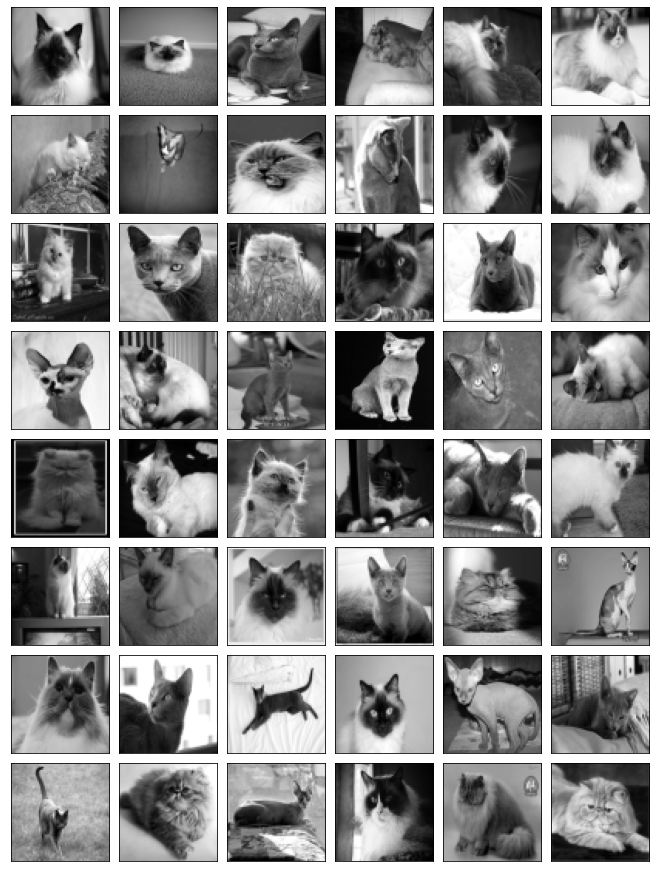


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



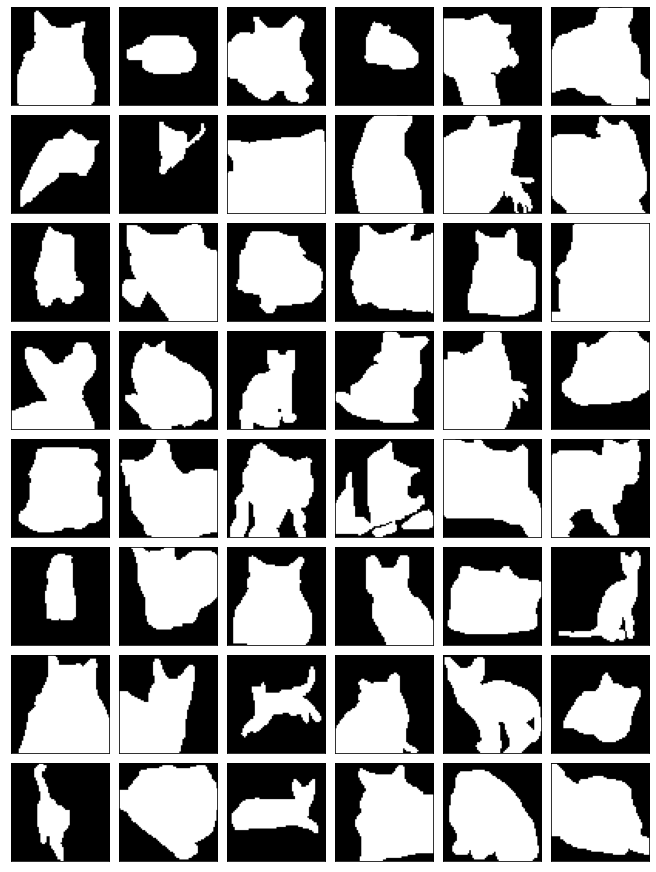


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



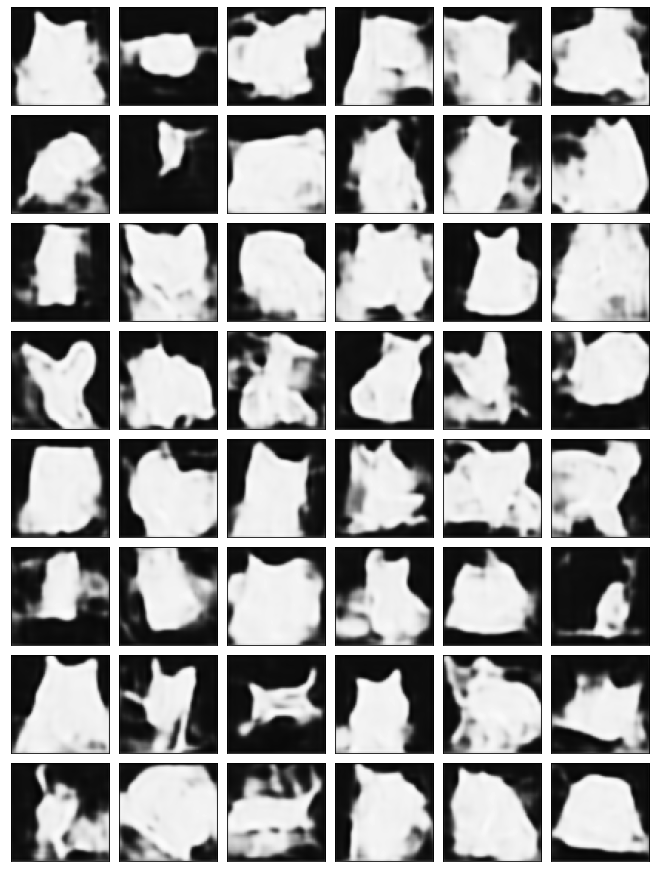


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



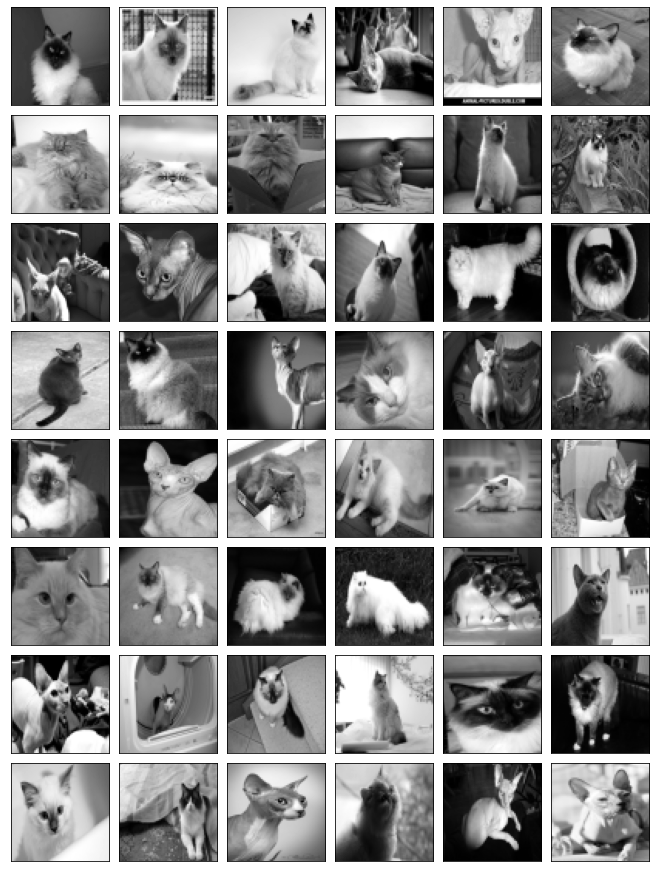


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



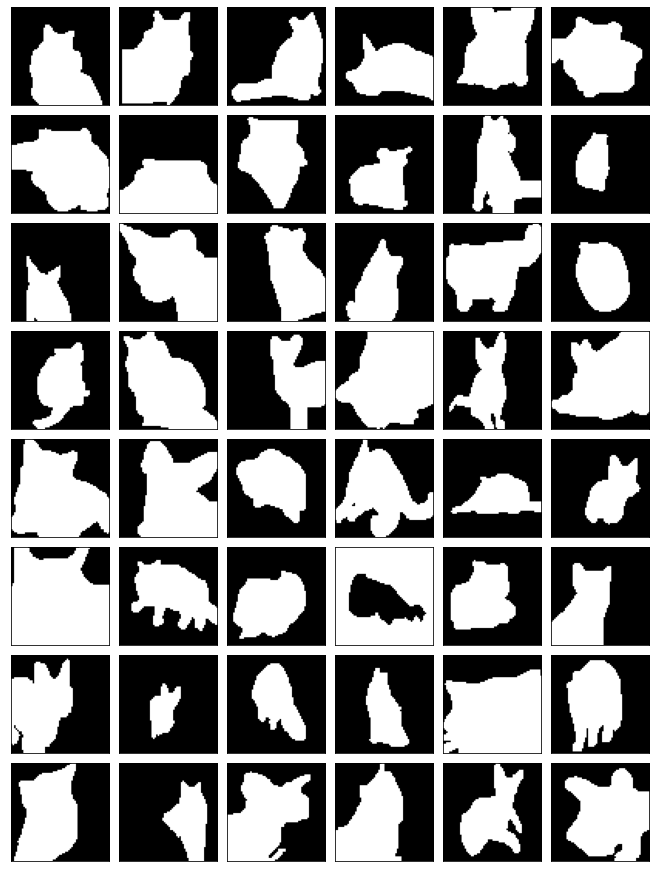


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



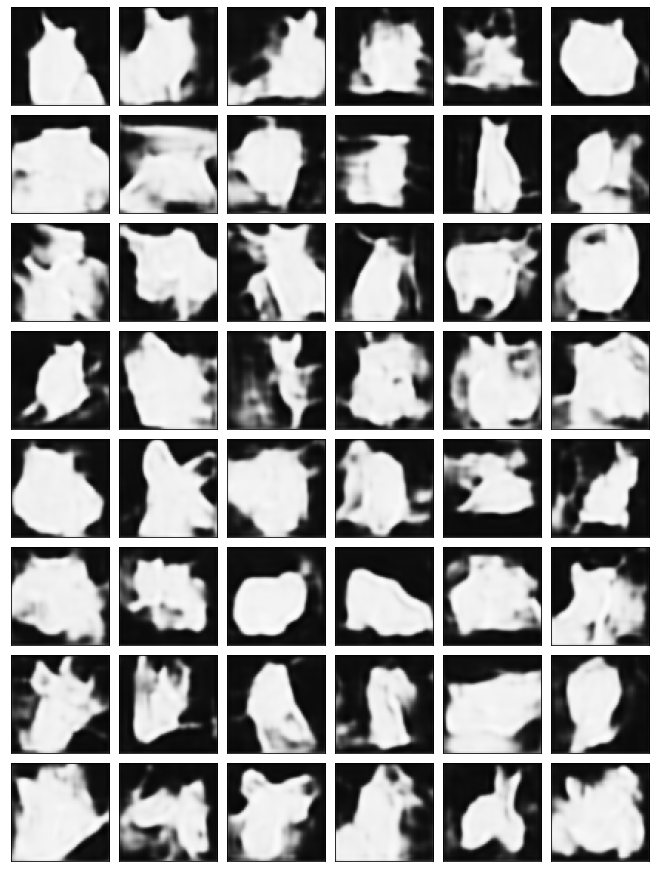


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



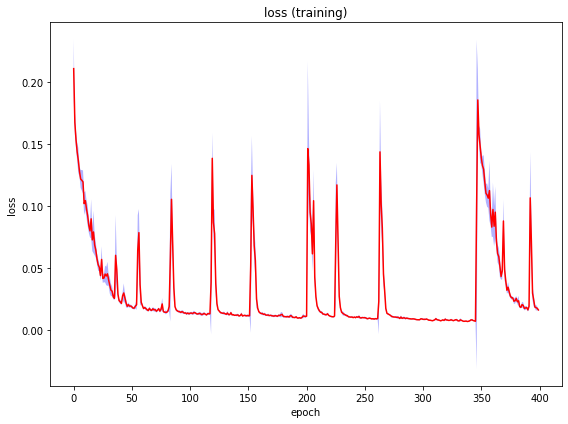


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



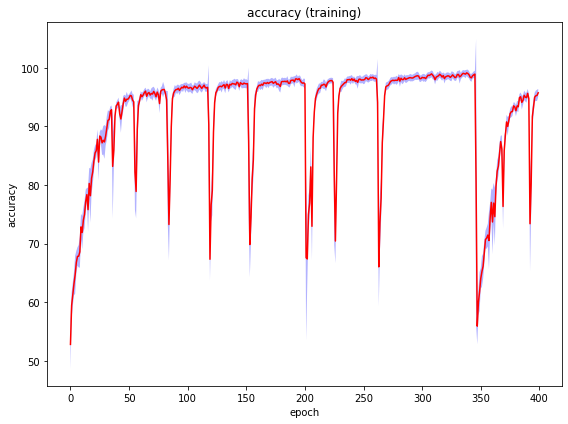


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



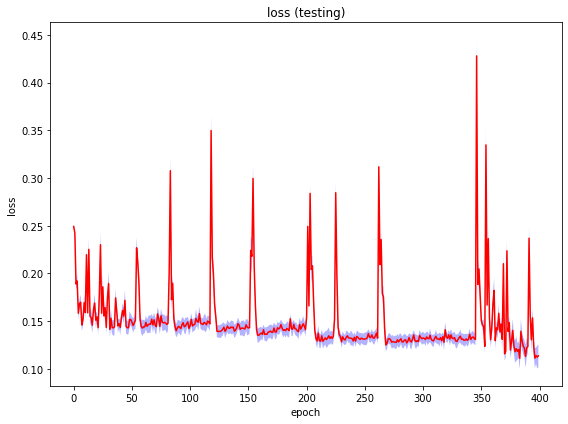


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



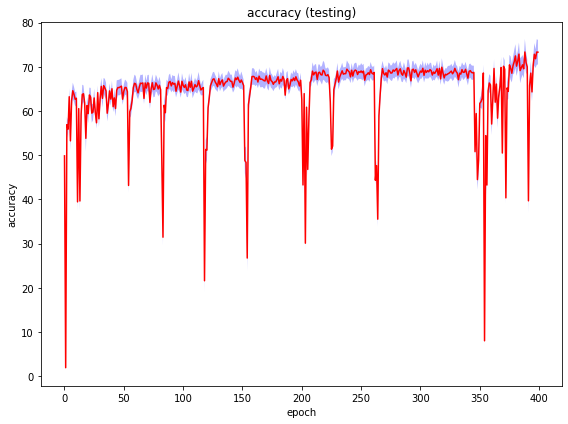


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0162100806
index =  1, value = 0.0190705623
index =  2, value = 0.1065511843
index =  3, value = 0.0711615874
index =  4, value = 0.0297389743
index =  5, value = 0.0240199206
index =  6, value = 0.0185373651
index =  7, value = 0.0179823296
index =  8, value = 0.0175099888
index =  9, value = 0.0161728330

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 95.6327912622
index =  1, value = 94.7468918666
index =  2, value = 73.3871439032
index =  3, value = 80.3288897564
index =  4, value = 91.6561024935
index =  5, value = 93.2496951440


In [370]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)